# Data Masters Case: Exploração inicial

Felipe Viacava -- São Paulo, ago/2023

O presente documento consiste na análise exploratória inicial dos dados fornecidos para a solução do Case "Data Masters - Cientista de Dados" do Santander Brasil. O objetivo é conhecer melhor os dados para definir com assertividade cada passo do processo de modelagem para as duas primeiras partes do projeto, que envolvem a classificação de clientes como satisfeitos ou insatisfeitos.

As premissas do presente documento são as seguintes:
- Os dados fornecidos são confiáveis e representam a realidade;
- Os dados fornecidos são suficientes para a solução do problema;
- O problema é bem definido e pode ser resolvido com técnicas de classificação;
- O objetivo é treinar o modelo com maior capacidade de predição possível, independente de sua explicabilidade;
- A análise exploratória deve contemplar apenas um subconjunto dos dados para evitar _data leakage_, garantindo que a etapa de testes seja a mais próxima possível de um modelo em produção, sem qualquer viés decorrente dessa etapa;
- Nenhuma transformação realizada nesta etapa deve ser gravada em disco. Aqui, os passos de transformação serão definidos para aplicação nos _pipelines_ de classificação, garantindo maior reprodutibilidade e facilidade de manutenção;
- Dada a quantidade de variáveis, seus prefixos e a ausência de metadados que descrevam suas características e seus propósitos de negócio, assumiu-se o contexto da empresa Santander Brasil enquanto banco para realizar suposições sobre as variáveis. Cada grupo de variáveis tem sua própria seção neste documento com suas premissas e análises. 

## Bibliotecas

In [1]:
# --- Data Exploration --- #
import pandas as pd
import missingno as mno
import matplotlib.pyplot as plt
import resources.customviz as cv
from resources.edautils import neg_pos_zero

# --- Data Processing --- #
import numpy as np
from sklearn.model_selection import train_test_split
from resources.customtransformers import \
    DropConstantColumns, \
    DropDuplicateColumns, \
    AddNonZeroCount, \
    CustomSum, \
    CustomImputer, \
    AddNoneCount, \
    CustomEncoder

# --- Setting Global Options --- #
pd.options.display.max_columns = None
pd.options.display.max_rows = None

## Separação em treino e teste

Como explicitado nas premissas deste documento, o conjunto de dados foi dividido entre treino e teste para evitar _data leakage_. Utilizamos 80% do conjunto original, estratificado pela variável de interesse ("TARGET").

In [2]:
df = pd.read_csv("data/train.csv")

df.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var1,ind_var2_0,ind_var2,ind_var5_0,ind_var5,ind_var6_0,ind_var6,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13_largo,ind_var13_medio_0,ind_var13_medio,ind_var13,ind_var14_0,ind_var14,ind_var17_0,ind_var17,ind_var18_0,ind_var18,ind_var19,ind_var20_0,ind_var20,ind_var24_0,ind_var24,ind_var25_cte,ind_var26_0,ind_var26_cte,ind_var26,ind_var25_0,ind_var25,ind_var27_0,ind_var28_0,ind_var28,ind_var27,ind_var29_0,ind_var29,ind_var30_0,ind_var30,ind_var31_0,ind_var31,ind_var32_cte,ind_var32_0,ind_var32,ind_var33_0,ind_var33,ind_var34_0,ind_var34,ind_var37_cte,ind_var37_0,ind_var37,ind_var39_0,ind_var40_0,ind_var40,ind_var41_0,ind_var41,ind_var39,ind_var44_0,ind_var44,ind_var46_0,ind_var46,num_var1_0,num_var1,num_var4,num_var5_0,num_var5,num_var6_0,num_var6,num_var8_0,num_var8,num_var12_0,num_var12,num_var13_0,num_var13_corto_0,num_var13_corto,num_var13_largo_0,num_var13_largo,num_var13_medio_0,num_var13_medio,num_var13,num_var14_0,num_var14,num_var17_0,num_var17,num_var18_0,num_var18,num_var20_0,num_var20,num_var24_0,num_var24,num_var26_0,num_var26,num_var25_0,num_var25,num_op_var40_hace2,num_op_var40_hace3,num_op_var40_ult1,num_op_var40_ult3,num_op_var41_hace2,num_op_var41_hace3,num_op_var41_ult1,num_op_var41_ult3,num_op_var39_hace2,num_op_var39_hace3,num_op_var39_ult1,num_op_var39_ult3,num_var27_0,num_var28_0,num_var28,num_var27,num_var29_0,num_var29,num_var30_0,num_var30,num_var31_0,num_var31,num_var32_0,num_var32,num_var33_0,num_var33,num_var34_0,num_var34,num_var35,num_var37_med_ult2,num_var37_0,num_var37,num_var39_0,num_var40_0,num_var40,num_var41_0,num_var41,num_var39,num_var42_0,num_var42,num_var44_0,num_var44,num_var46_0,num_var46,saldo_var1,saldo_var5,saldo_var6,saldo_var8,saldo_var12,saldo_var13_corto,saldo_var13_largo,saldo_var13_medio,saldo_var13,saldo_var14,saldo_var17,saldo_var18,saldo_var20,saldo_var24,saldo_var26,saldo_var25,saldo_var28,saldo_var27,saldo_var29,saldo_var30,saldo_var31,saldo_var32,saldo_var33,saldo_var34,saldo_var37,saldo_var40,saldo_var41,saldo_var42,saldo_var44,saldo_var46,var36,delta_imp_amort_var18_1y3,delta_imp_amort_var34_1y3,delta_imp_aport_var13_1y3,delta_imp_aport_var17_1y3,delta_imp_aport_var33_1y3,delta_imp_compra_var44_1y3,delta_imp_reemb_var13_1y3,delta_imp_reemb_var17_1y3,delta_imp_reemb_var33_1y3,delta_imp_trasp_var17_in_1y3,delta_imp_trasp_var17_out_1y3,delta_imp_trasp_var33_in_1y3,delta_imp_trasp_var33_out_1y3,delta_imp_venta_var44_1y3,delta_num_aport_var13_1y3,delta_num_aport_var17_1y3,delta_num_aport_var33_1y3,delta_num_compra_var44_1y3,delta_num_reemb_var13_1y3,delta_num_reemb_var17_1y3,delta_num_reemb_var33_1y3,delta_num_trasp_var17_in_1y3,delta_num_trasp_var17_out_1y3,delta_num_trasp_var33_in_1y3,delta_num_trasp_var33_out_1y3,delta_num_venta_var44_1y3,imp_amort_var18_hace3,imp_amort_var18_ult1,imp_amort_var34_hace3,imp_amort_var34_ult1,imp_aport_var13_hace3,imp_aport_var13_ult1,imp_aport_var17_hace3,imp_aport_var17_ult1,imp_aport_var33_hace3,imp_aport_var33_ult1,imp_var7_emit_ult1,imp_var7_recib_ult1,imp_compra_var44_hace3,imp_compra_var44_ult1,imp_reemb_var13_hace3,imp_reemb_var13_ult1,imp_reemb_var17_hace3,imp_reemb_var17_ult1,imp_reemb_var33_hace3,imp_reemb_var33_ult1,imp_var43_emit_ult1,imp_trans_var37_ult1,imp_trasp_var17_in_hace3,imp_trasp_var17_in_ult1,imp_trasp_var17_out_hace3,imp_trasp_var17_out_ult1,imp_trasp_var33_in_hace3,imp_trasp_var33_in_ult1,imp_trasp_var33_out_hace3,imp_trasp_var33_out_ult1,imp_venta_var44_hace3,imp_venta_var44_ult1,ind_var7_emit_ult1,ind_var7_recib_ult1,ind_var10_ult1,ind_var10

## Análise Exploratória e Feature Engineering

A análise exploratória segue as premissas descritas no cabeçalho deste documento, e foi dividida em 3 partes:
- Análise generalizada, onde se detectou a presença de colunas constantes e/ou duplicadas;
- Análise por prefixo, onde se assumiram as mesmas premissas para variáveis com o mesmo prefixo;
- Análise individual para variáveis sem prefixos.

Cada parte inclui apenas as colunas que não foram descartadas nas etapas anteriores, ou seja: uma variável de prefixo "ind" que tenha sido encontrada como constante ou duplicada na primeira etapa de análise (e processamento, durante a transformação no _pipeline_) não foi analisada durante a seção de seu prefixo.

Muitas variáveis compartilham o nome principal ("var30", por exemplo), indicando que uma variável de prefixo "ind" por ser um indicador de uma variável de prefixo "saldo". Contudo, por haver muitos nomes, esta relação foi deixada como um ponto a melhorar em futuras versões deste _case_.

### Removendo variáveis constantes e duplicadas

Percebeu-se a existência de variáveis constantes e/ou duplicadas.

Variáveis aleatórias constantes não servem propósito algum na modelagem e ocupam espaço na memória, aumentando o custo computacional sem qualquer benefício na predição. Isso motiva a criação de um transformador customizado que detecta estas variáveis durante o _fit_ (considerando apenas o subconjunto de treino) e as remove durante a transformação (tanto no subconjunto de treino quanto no de teste).

Variáveis duplicadas, por outro lado, levam à multicolinearidade, que pode impactar negativamente qualquer modelo estatístico -- tanto em poder preditivo quanto em explicabilidade.

Os dois transformadores utilizados para realizar esta operação são _DropConstantColumns_ e _DropDuplicateColumns_, encontrados no arquivo "customtransformers.py", na pasta "resources" deste projeto.

### Valores faltantes

Percebeu-se que não há nenhum valor faltante no conjunto de dados. Isso indica que, possivelmente, estes dados passaram por algum tratamento prévio, onde os valores faltantes foram preenchidos ou removidos. A investigação sobre dados faltantes, nesta análise, é própria de cada prefixo ou variável sem prefixo.

In [3]:
#| label: dupeconstdrop
#| echo: true
#| code-fold: show
#| code-summary: "Código"
dcc = DropConstantColumns(print_cols=True)
dcc = dcc.fit(df)
df = dcc.transform(df)

ddc = DropDuplicateColumns(print_cols=True)
ddc = ddc.fit(df)
df = ddc.transform(df)

print(f"{df.isna().sum().sum()} missing values found.")

54 constant columns were found.
23 duplicate columns were found.
0 missing values found.


### ID e TARGET

ID:

Assumiu-se que esta coluna é o ID anonimizado de cada observação (cliente) da base, tanto pelo nome quanto por não conter nenhum valor duplicado ou faltante. Esta coluna não deve ser usada em hipótese alguma durante o treinamento pois, por ser uma chave única, não há como generalizar o aprendizado sobre ela para novos clientes (_overfitting_).

TARGET:

Assumiu-se que esta é a variável de interesse do problema por conta de seu nome e por ser binária (considerando que este é um problema de classificação binária). Dada a proporção de clientes insatisfeitos, é necessário validar o corte de classificação antes de classificar os clientes, além de usar os parâmetros feitos para lidar com este tipo de problema (como _class weight_) quando possível.

In [4]:
#| label: id-target
#| echo: true
#| code-fold: true
#| code-summary: "Código"
nu = df["ID"].nunique() / df.shape[0]
print(f"Valores únicos em ID: {100*nu:.2f}%")
prop = df["TARGET"].value_counts(normalize=True).reset_index().set_index("TARGET")
print(f"TARGET = 0: {100*prop['proportion'][0]:.2f}%")
print(f"TARGET = 1: {100*prop['proportion'][1]:.2f}%")

Valores únicos em ID: 100.00%
TARGET = 0: 96.04%
TARGET = 1: 3.96%


### Saldo

Assumiu-se, partindo das premissas descritas no cabeçalho, que esta é uma variável numérica, pois o prefixo "saldo" sugere que se trata de uma valor monetário. Como são muitas colunas, entende-se que se trata do saldo que um cliente tem em diversos produtos financeiros.

Números decimais, números negativos (no caso de um produto como Cheque Especial) e muitos valores únicos corroboram esta hipótese, assim como a esparsidade destes dados: com algum conhecimento de negócios, podemos inferir que é incomum um cliente possuir saldo em todos os produtos financeiros que o banco oferece.

Para detectar clientes com muitos produtos, foi criado o transformador "_AddNonZeroCount_", que conta a quantidade de valores diferentes de zero um cliente tem nas colunas mesmo prefixo. Essa variável mostra que clientes com mais produtos tendem a ser mais satisfeitos -- o que faz sentido, pois mostra que com maior satisfação, o cliente tende a adquirir mais produtos. Na verdade, a suma maioria dos clientes insatisfeitos se concentra em 0.

Para encontrar a diferença entre os saldos dos clientes de modo geral, foi criado o transformador "_CustomSum_", que soma os valores de todas as colunas com o mesmo prefixo. Diferentemente da contagem de não-zeros, essa variável não aparenta ter poder de discriminação relevante

#### Verificações generalizadas

In [5]:
#| label: saldo-describe
#| echo: true
#| code-fold: true
#| code-summary: "Código"
saldo_cols = [
    col
    for col in df.columns
    if col.startswith("saldo")
]

df[saldo_cols].describe()

,saldo_var1,saldo_var5,saldo_var8,saldo_var12,saldo_var13_corto,saldo_var13_largo,saldo_var13,saldo_var14,saldo_var17,saldo_var18,saldo_var20,saldo_var24,saldo_var26,saldo_var25,saldo_var29,saldo_var30,saldo_var31,saldo_var32,saldo_var33,saldo_var37,saldo_var40,saldo_var42,saldo_var44,saldo_medio_var5_hace2,saldo_medio_var5_hace3,saldo_medio_var5_ult1,saldo_medio_var5_ult3,saldo_medio_var8_hace2,saldo_medio_var8_hace3,saldo_medio_var8_ult1,saldo_medio_var8_ult3,saldo_medio_var12_hace2,saldo_medio_var12_hace3,saldo_medio_var12_ult1,saldo_medio_var12_ult3,saldo_medio_var13_corto_hace2,saldo_medio_var13_corto_hace3,saldo_medio_var13_corto_ult1,saldo_medio_var13_corto_ult3,saldo_medio_var13_largo_hace2,saldo_medio_var13_largo_hace3,saldo_medio_var13_largo_ult1,saldo_medio_var13_largo_ult3,saldo_medio_var17_hace2,saldo_medio_var17_hace3,saldo_medio_var17_ult1,saldo_medio_var17_ult3,saldo_medio_var29_hace2,saldo_medio_var29_hace3,saldo_medio_var29_ult1,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3
count,5.701500e+04,57015.000000,57015.000000,5.701500e+04,57015.000000,5.701500e+04,5.701500e+04,57015.000000,5.701500e+04,5.701500e+04,57015.000000,5.701500e+04,57015.000000,57015.00000,57015.000000,5.701500e+04,5.701500e+04,57015.000000,57015.000000,57015.000000,57015.000000,5.701500e+04,57015.000000,57015.000000,5.701500e+04,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,5.701500e+04,57015.000000,5.701500e+04,5.701500e+04,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,5.701500e+04,5.701500e+04,5.701500e+04,5.701500e+04,5.701500e+04,5.701500e+04,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000
mean,5.647377e+01,1022.886994,148.382236,6.199680e+03,5043.312059,1.615135e+03,6.658447e+03,75.408646,2.280693e+02,5.261773e+01,30.574473,6.093697e+03,77.819255,74.31219,0.552634,1.402995e+04,3.477103e+02,3.507064,6.802496,38.415775,3.856036,7.371502e+03,112.838445,1579.223329,8.886114e+02,1087.701298,1060.380299,72.142799,9.915621,130.781521,114.667478,4.144313e+03,642.496189,5.888456e+03,4.520353e+03,3641.106408,563.469897,4905.352849,3893.801718,835.691014,175.699469,1.039760e+03,8.149678e+02,1.112751e+02,4.772609e+01,1.610807e+02,1.343335e+02,0.284095,0.002547,0.338542,0.248840,5.134473,0.970980,6.747690,4.802795,34.787668,1.683645,85.491811,64.562739
std,1.256438e+04,9585.151279,2674.921373,5.046542e+04,32941.531827,2.117787e+04,3.930945e+04,3135.619158,2.617611e+04,1.256396e+04,2836.440607,5.030050e+04,778.339337,764.19930,95.951729,6.551689e+04,2.685425e+04,133.813397,441.867908,512.919169,104.321349,5.136950e+04,5916.053871,12018.675179,1.048953e+04,9402.311934,8168.239694,1876.609553,494.372570,2286.641030,1951.417607,4.036733e+04,9786.216189,4.862178e+04,3.699663e+04,26377.374116,7323.317321,32191.041402,25734.410218,13702.722377,4857.309719,1.704264e+04,1.313540e+04,1.775392e+04,9.943442e+03,1.723843e+04,1.508243e+04,48.289987,0.608096,60.135284,36.811052,352.560232,83.872097,439.445853,300.110789,2260.794741,143.601303,4518.340854,3202.202490
min,0.000000e+00,-1842.000000,-4942.260000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.00000,0.000000,-4.942260e+03,0.000000e+00,0.000000,0.000000,0.000000,0.000000,-4.942260e+03,0.000000,-128.370000,-8.040000e+00,-922.380000,-476.070000,-287.670000,0.000000,-3401.340000,-1844.520000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,-3.000000e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000e+00,0.000000,0.00000

In [6]:
df[saldo_cols] \
    .nunique() \
    .nlargest(5) \
    .reset_index() \
    .rename(
        mapper={
            "index": "Column",
            0: "Number of unique values"
        },
        axis=1
    ) \
    .set_index("Column")

,Number of unique values
Column,
saldo_medio_var5_ult3,13846
saldo_var30,13225
saldo_var42,12242
saldo_medio_var5_ult1,11621
saldo_medio_var5_hace2,11478


In [7]:
neg_pos_zero(df, saldo_cols) # Esta função foi criada no arquivo "edautils.py"

,Column,Negative values (%),Positive values (%),Zero values (%)
0,saldo_var1,0.000000,0.350785,99.649215
31,saldo_medio_var12_hace2,0.000000,3.981408,96.018592
32,saldo_medio_var12_hace3,0.000000,1.704815,98.295185
33,saldo_medio_var12_ult1,0.000000,4.602298,95.397702
34,saldo_medio_var12_ult3,0.000000,4.602298,95.397702
35,saldo_medio_var13_corto_hace2,0.000000,3.900728,96.099272
36,saldo_medio_var13_corto_hace3,0.000000,1.781987,98.218013
37,saldo_medio_var13_corto_ult1,0.000000,4.184864,95.815136
38,saldo_medio_var13_corto_ult3,0.000000,4.184864,95.815136
39,saldo_medio_var13_largo_hace2,0.000000,0.675261,99.324739


#### Feature engineering

##### Contagem de colunas diferentes de 0

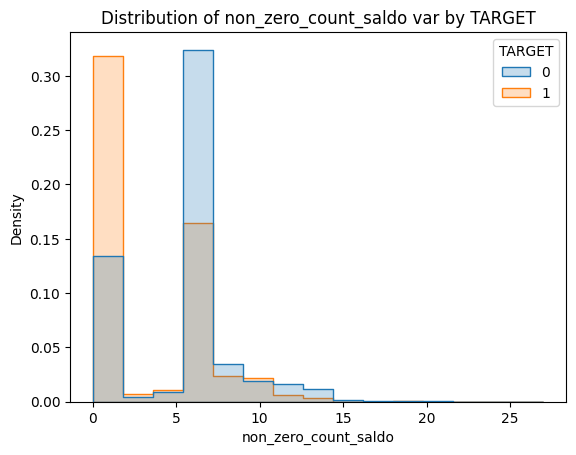

In [8]:
#| label: saldo-nonzero
#| echo: true
#| code-fold: true
#| code-summary: "Código"
anzc_saldo = AddNonZeroCount(prefix="saldo")
anzc_saldo = anzc_saldo.fit(df)
df = anzc_saldo.transform(df)
col = "non_zero_count_saldo"
cv.binaryhistplot(x=df[col], hue=df["TARGET"], nbins=15)

##### Soma total das colunas

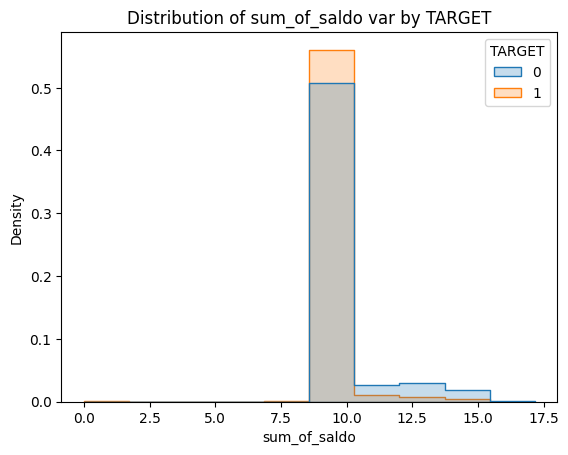

In [9]:
#| label: saldo-sum
#| echo: true
#| code-fold: true
#| code-summary: "Código"

cs_saldo = CustomSum(prefix="saldo")
cs_saldo = cs_saldo.fit(df)
df = cs_saldo.transform(df)
col = "sum_of_saldo"
min_sum = df[col].min()
cv.binaryhistplot(
    x=df[col].apply(lambda x: np.log(x+1-min_sum)),
    hue=df["TARGET"],
    nbins=10
)

### Imp

Assumindo que "imp" se deriva de "imposición", ou seja, algum tipo de taxa, com caracteríticas semelhantes às descritas no subset de "saldo"(com excessão de valores negativos, que aqui não existem), também partimos do pressuposto de que estas são variáveis numéricas. Foram criadas as mesmas colunas que no subset de "saldo", com exceção da coluna de saldo médio por produto.

Neste caso, nenhuma das variáveis criadas parece ter poder de discriminação.

#### Verificações generalizadas

In [10]:
#| label: imp-describe
#| echo: true
#| code-fold: true
#| code-summary: "Código"

imp_cols = [
    col
    for col in df.columns
    if col.startswith("imp")
]

df[imp_cols].describe()

,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_sal_var16_ult1,imp_amort_var18_ult1,imp_aport_var13_hace3,imp_aport_var13_ult1,imp_aport_var17_hace3,imp_aport_var17_ult1,imp_aport_var33_hace3,imp_aport_var33_ult1,imp_var7_emit_ult1,imp_var7_recib_ult1,imp_compra_var44_hace3,imp_compra_var44_ult1,imp_reemb_var13_ult1,imp_reemb_var17_hace3,imp_reemb_var17_ult1,imp_var43_emit_ult1,imp_trans_var37_ult1,imp_trasp_var17_in_hace3,imp_trasp_var17_in_ult1,imp_trasp_var17_out_ult1,imp_trasp_var33_in_hace3,imp_trasp_var33_in_ult1,imp_trasp_var33_out_ult1,imp_venta_var44_hace3,imp_venta_var44_ult1
count,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,5.701500e+04,57015.000000,57015.000000,57015.000000,57015.000000,5.701500e+04,57015.000000,5.701500e+04,57015.000000,57015.000000,57015.000000,57015.000000,5.701500e+04,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,5.701500e+04
mean,81.003089,71.913524,118.994372,3.083158,5.752563,0.365381,0.535336,2.829000,68.830367,113.241809,67.552170,111.873221,136.944608,67.917551,112.408557,139.773609,4.233566,0.275222,2873.495172,635.007707,1.277614e+02,36.573989,2.255196,0.036832,3.628605,1.452222e+02,12.487925,1.506857e+02,48.314042,0.210947,13.714707,868.027511,1.931449e+03,2.499744,3.350238,2.495498,1.948178,0.184902,0.052618,1.369179,1.050151e+02
std,1366.949303,335.251692,543.966435,80.869729,140.495976,32.236893,38.987633,87.985696,318.924638,515.535254,531.479065,863.633698,703.052574,535.168344,867.890588,717.360016,294.988427,65.717071,25674.815161,11484.052874,2.553634e+04,2754.144279,202.168560,4.352167,639.990954,6.784845e+03,966.472697,1.572070e+04,3063.934595,50.369561,1206.186327,13840.787878,2.332046e+04,448.305976,587.705484,412.478795,271.121054,27.264123,12.563964,326.833072,1.301850e+04
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
max,135000.000000,9968.040000,16086.060000,8237.820000,10351.950000,6600.000000,6600.000000

In [11]:
df[imp_cols] \
    .nunique() \
    .sort_values() \
    .reset_index() \
    .rename(
        mapper={
            "index": "Column",
            0: "Number of unique values"
        },
        axis=1
    )

,Column,Number of unique values
0,imp_trasp_var33_out_ult1,2
1,imp_amort_var18_ult1,2
2,imp_reemb_var17_hace3,2
3,imp_venta_var44_hace3,3
4,imp_trasp_var17_in_hace3,3
5,imp_trasp_var33_in_ult1,4
6,imp_trasp_var33_in_hace3,4
7,imp_trasp_var17_out_ult1,4
8,imp_var7_emit_ult1,4
9,imp_aport_var33_ult1,5


#### Feature Engineering

##### Contagem de colunas diferentes de 0

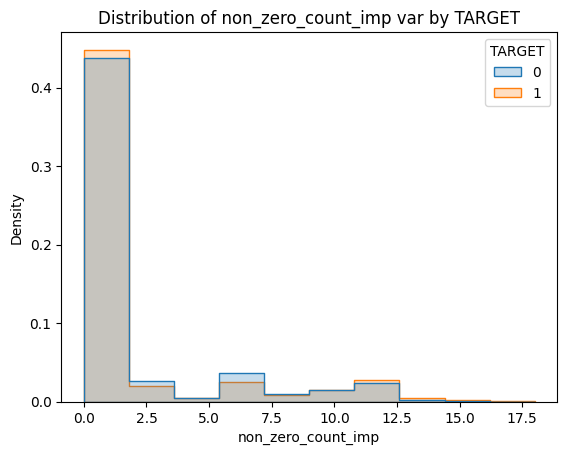

In [12]:
#| label: imp-nonzero
#| echo: true
#| code-fold: true
#| code-summary: "Código"

anzc_imp = AddNonZeroCount(prefix="imp")
anzc_imp = anzc_imp.fit(df)
df = anzc_imp.transform(df)
col = "non_zero_count_imp"
cv.binaryhistplot(df[col], df["TARGET"], nbins=10)

##### Soma total das colunas

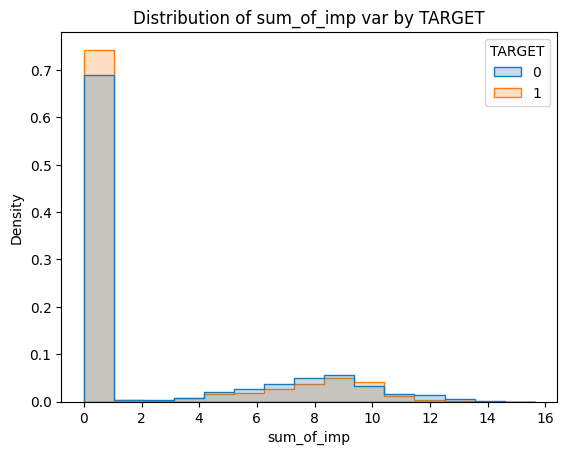

In [13]:
#| label: imp-sum
#| echo: true
#| code-fold: true
#| code-summary: "Código"

cs_imp = CustomSum(prefix="imp")
cs_imp = cs_imp.fit(df)
df = cs_imp.transform(df)
col = "sum_of_imp"
cv.binaryhistplot(df["sum_of_imp"].apply(lambda x: np.log(x + 1)), df["TARGET"], nbins=15)

### Delta

O nome da coluna sugere que seja algum tipo de variação. Assim, também assumimos que se trata de uma variável numérica. Mesmo que haja poucos valores únicos, aqueles que são diferentes de zero são, em geral, negativos ou decimais.

Diferentemente dos demais subconjuntos estudados até o momento, acredita-se haver valores nulos neste subconjunto, mas que foram preenchidos com 9999999999. Todas as colunas deste subconjunto compartilham este valor como valor máximo, sendo que ao removê-lo o maior valor máximo é de 8. Um transformador customizado foi criado para preencher estes valores falsos com _np.nan_.

Em seguida, foi criado um transformador para contar valores nulos neste subconjunto, mas a variável criada não aparenta ter poder de discriminação, assim como a contagem de não-zeros e a soma total.

Como lidar com valores nulos varia para cada problema e seu respectivo conjunto de dados. O próprio _sklearn_ implementa _KNN_ para preencher campos vazios. Essa abordagem é funcional pois as distâncias dos vizinhos mais próximos de uma determinada observação serão calculadas com base apenas em suas variáveis devidamente preenchidas.

Contudo, o _KNNImputer_ precisa de uma série de preprocessamentos e considerações antes do uso:
- Medida de distância razoável para os tipos das variáveis no conjunto de dados.
- Pré-processamento cuidadoso, ajustando a escala das variáveis de forma que façam sentido para a medida de distância escolhida.
- Tratamento da multicolinearidade, pois variáveis com forte correlação aumentam a distância entre observações sem agregar mais informação.

Um processamento cauteloso dos dados envolveria estudar cada variável individualmente para entender sua distribuição e, então, tomar as decisões necessárias sobre seu preprocessamento. Para esta entrega, optou-se por utilizar modelos baseados em árvores, pois estes não assumem qualquer tipo de distribuição.

A escolha do modelo usado também afeta na decisão de como tratar os valores faltantes. No _sklearn_, árvores de decisão e modelos de _boosting_ têm uma estratégia própria para lidar com valores faltantes. Em cada nó, os algoritmos encontram o _split_ que minimiza a função de custo desconsiderando valores faltantes. Encontrado este split, os modelos testam em qual dos nós filhos as observações com valores faltantes devem ser alocadas: o nó filho que minimiza a função de custo é o escolhido. Estes modelos também testam se o melhor _split_ é, na verdade, separar faltantes de preenchidos, eliminando também a necessidade de criar uma _flag_ para nulo em determinada coluna.

Contudo, a implementação de florestas aleatórias do _sklearn_ ainda não oferece esta funcionalidade. Neste caso, optou-se por preencher os valores faltantes com a mediana. Dada a distribuição das variáveis (avaliadas pelo _df.describe_ deste prefixo), preencher os dados com a mediana é essencialmente o mesmo que preenche-los com 0, pois são dados esparsos.

Percebe-se também que há correlação entre observações na presença de valores nulos em mais de uma coluna, mas apenas entre variáveis com nomes semelhantes -- corroborando a ideia de que muitas das variáveis estão diretamente relacionadas umas com as outras.

Foram criadas variáveis de contagem de nulos, contagem de valores diferentes de zero e soma do subconjunto, sendo que nenhuma delas parece ter poder de discriminação.

#### Verificações generalizadas

In [14]:
delta_cols = [
    col
    for col in df.columns
    if col.startswith("delta")
]

df[delta_cols].describe()

,delta_imp_amort_var18_1y3,delta_imp_aport_var13_1y3,delta_imp_aport_var17_1y3,delta_imp_aport_var33_1y3,delta_imp_compra_var44_1y3,delta_imp_reemb_var13_1y3,delta_imp_reemb_var17_1y3,delta_imp_trasp_var17_in_1y3,delta_imp_trasp_var17_out_1y3,delta_imp_trasp_var33_in_1y3,delta_imp_trasp_var33_out_1y3,delta_imp_venta_var44_1y3,delta_num_aport_var13_1y3,delta_num_aport_var17_1y3,delta_num_aport_var33_1y3,delta_num_compra_var44_1y3,delta_num_venta_var44_1y3
count,5.701500e+04,5.701500e+04,5.701500e+04,5.701500e+04,5.701500e+04,5.701500e+04,5.701500e+04,5.701500e+04,5.701500e+04,5.701500e+04,5.701500e+04,5.701500e+04,5.701500e+04,5.701500e+04,5.701500e+04,5.701500e+04,5.701500e+04
mean,1.753924e+05,4.823292e+07,5.963343e+06,1.753924e+05,9.997369e+06,5.086381e+06,2.280102e+06,7.015698e+05,5.261773e+05,5.261773e+05,1.753924e+05,6.314128e+06,4.823292e+07,5.963343e+06,1.753924e+05,9.997369e+06,6.314128e+06
std,4.187988e+07,6.928284e+08,2.441289e+08,4.187988e+07,3.160308e+08,2.254747e+08,1.509842e+08,8.375756e+07,7.253681e+07,7.253681e+07,4.187988e+07,2.512021e+08,6.928284e+08,2.441289e+08,4.187988e+07,3.160308e+08,2.512021e+08
min,0.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10


In [15]:
df[delta_cols] \
    .nunique() \
    .sort_values() \
    .reset_index() \
    .rename(
        mapper={
            "index": "Column",
            0: "Number of unique values"
        },
        axis=1
    )

,Column,Number of unique values
0,delta_imp_amort_var18_1y3,2
1,delta_imp_trasp_var33_out_1y3,2
2,delta_imp_reemb_var13_1y3,2
3,delta_imp_trasp_var17_out_1y3,2
4,delta_imp_reemb_var17_1y3,3
5,delta_imp_trasp_var17_in_1y3,3
6,delta_imp_trasp_var33_in_1y3,3
7,delta_num_aport_var17_1y3,3
8,delta_imp_aport_var17_1y3,4
9,delta_imp_venta_var44_1y3,4


In [16]:
#| label: delta-describe
#| echo: true
#| code-fold: show
#| code-summary: "Código"
ci_delta = CustomImputer(prefix="delta", to_replace=9999999999)
ci_delta = ci_delta.fit(df)
df = ci_delta.transform(df)
df[delta_cols].describe()

,delta_imp_amort_var18_1y3,delta_imp_aport_var13_1y3,delta_imp_aport_var17_1y3,delta_imp_aport_var33_1y3,delta_imp_compra_var44_1y3,delta_imp_reemb_var13_1y3,delta_imp_reemb_var17_1y3,delta_imp_trasp_var17_in_1y3,delta_imp_trasp_var17_out_1y3,delta_imp_trasp_var33_in_1y3,delta_imp_trasp_var33_out_1y3,delta_imp_venta_var44_1y3,delta_num_aport_var13_1y3,delta_num_aport_var17_1y3,delta_num_aport_var33_1y3,delta_num_compra_var44_1y3,delta_num_venta_var44_1y3
count,57014.0,56740.000000,56981.000000,57014.000000,56958.000000,56986.0,57002.000000,57011.000000,57012.0,57012.000000,57014.0,56979.000000,56740.000000,56981.000000,57014.000000,56958.000000,56979.000000
mean,0.0,-0.022012,-0.000219,-0.000247,0.000009,0.0,-0.000018,-0.000035,0.0,-0.000053,0.0,0.000078,-0.022259,-0.000246,-0.000202,0.000050,0.000123
std,0.0,0.152221,0.016886,0.015401,0.036869,0.0,0.004188,0.005923,0.0,0.007254,0.0,0.023077,0.147766,0.015673,0.014046,0.030126,0.033775
min,0.0,-1.000000,-1.000000,-1.000000,-1.000000,0.0,-1.000000,-1.000000,0.0,-1.000000,0.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.0,5.500000,1.500000,0.000000,6.267608,0.0,0.000000,0.000000,0.0,0.000000,0.0,5.417098,1.000000,0.000000,0.000000,4.000000,8.000000


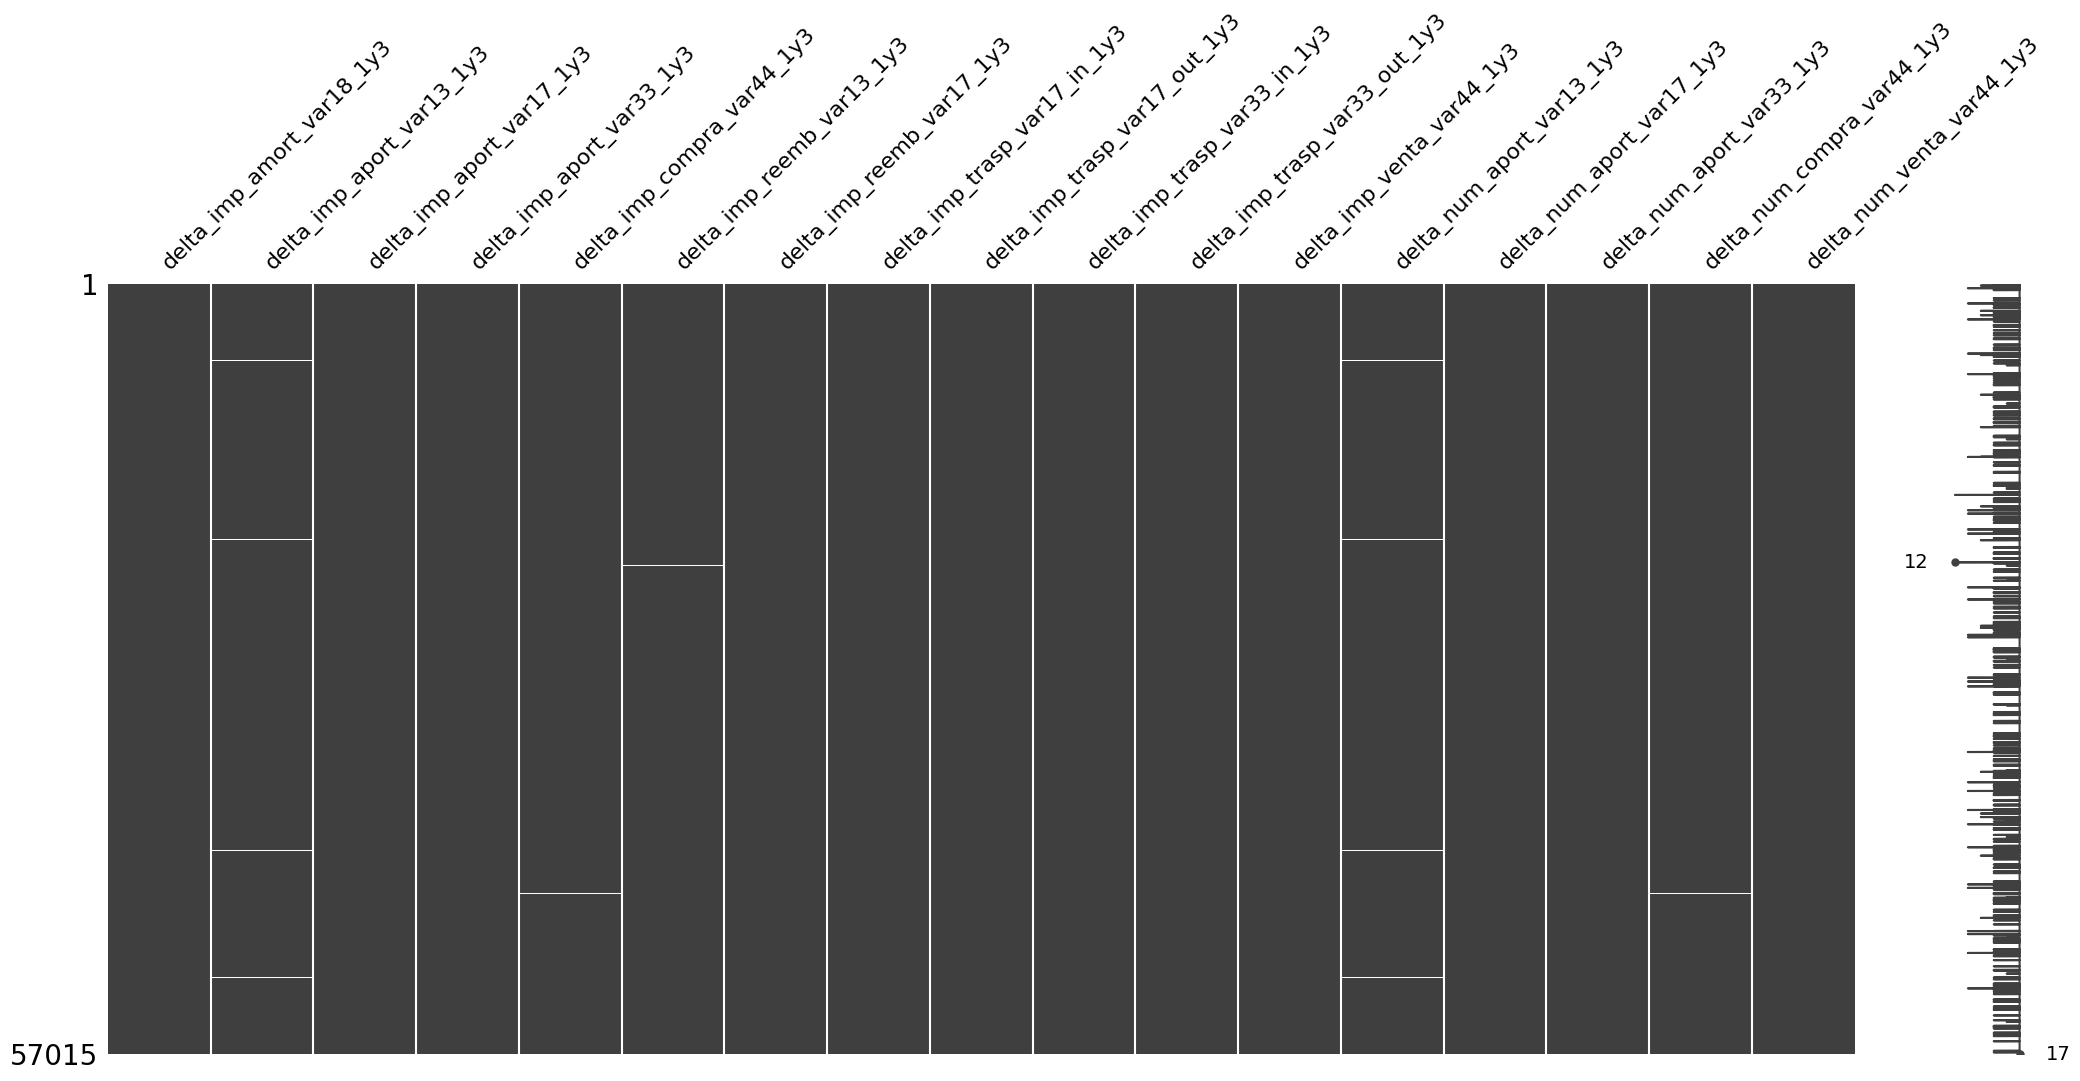

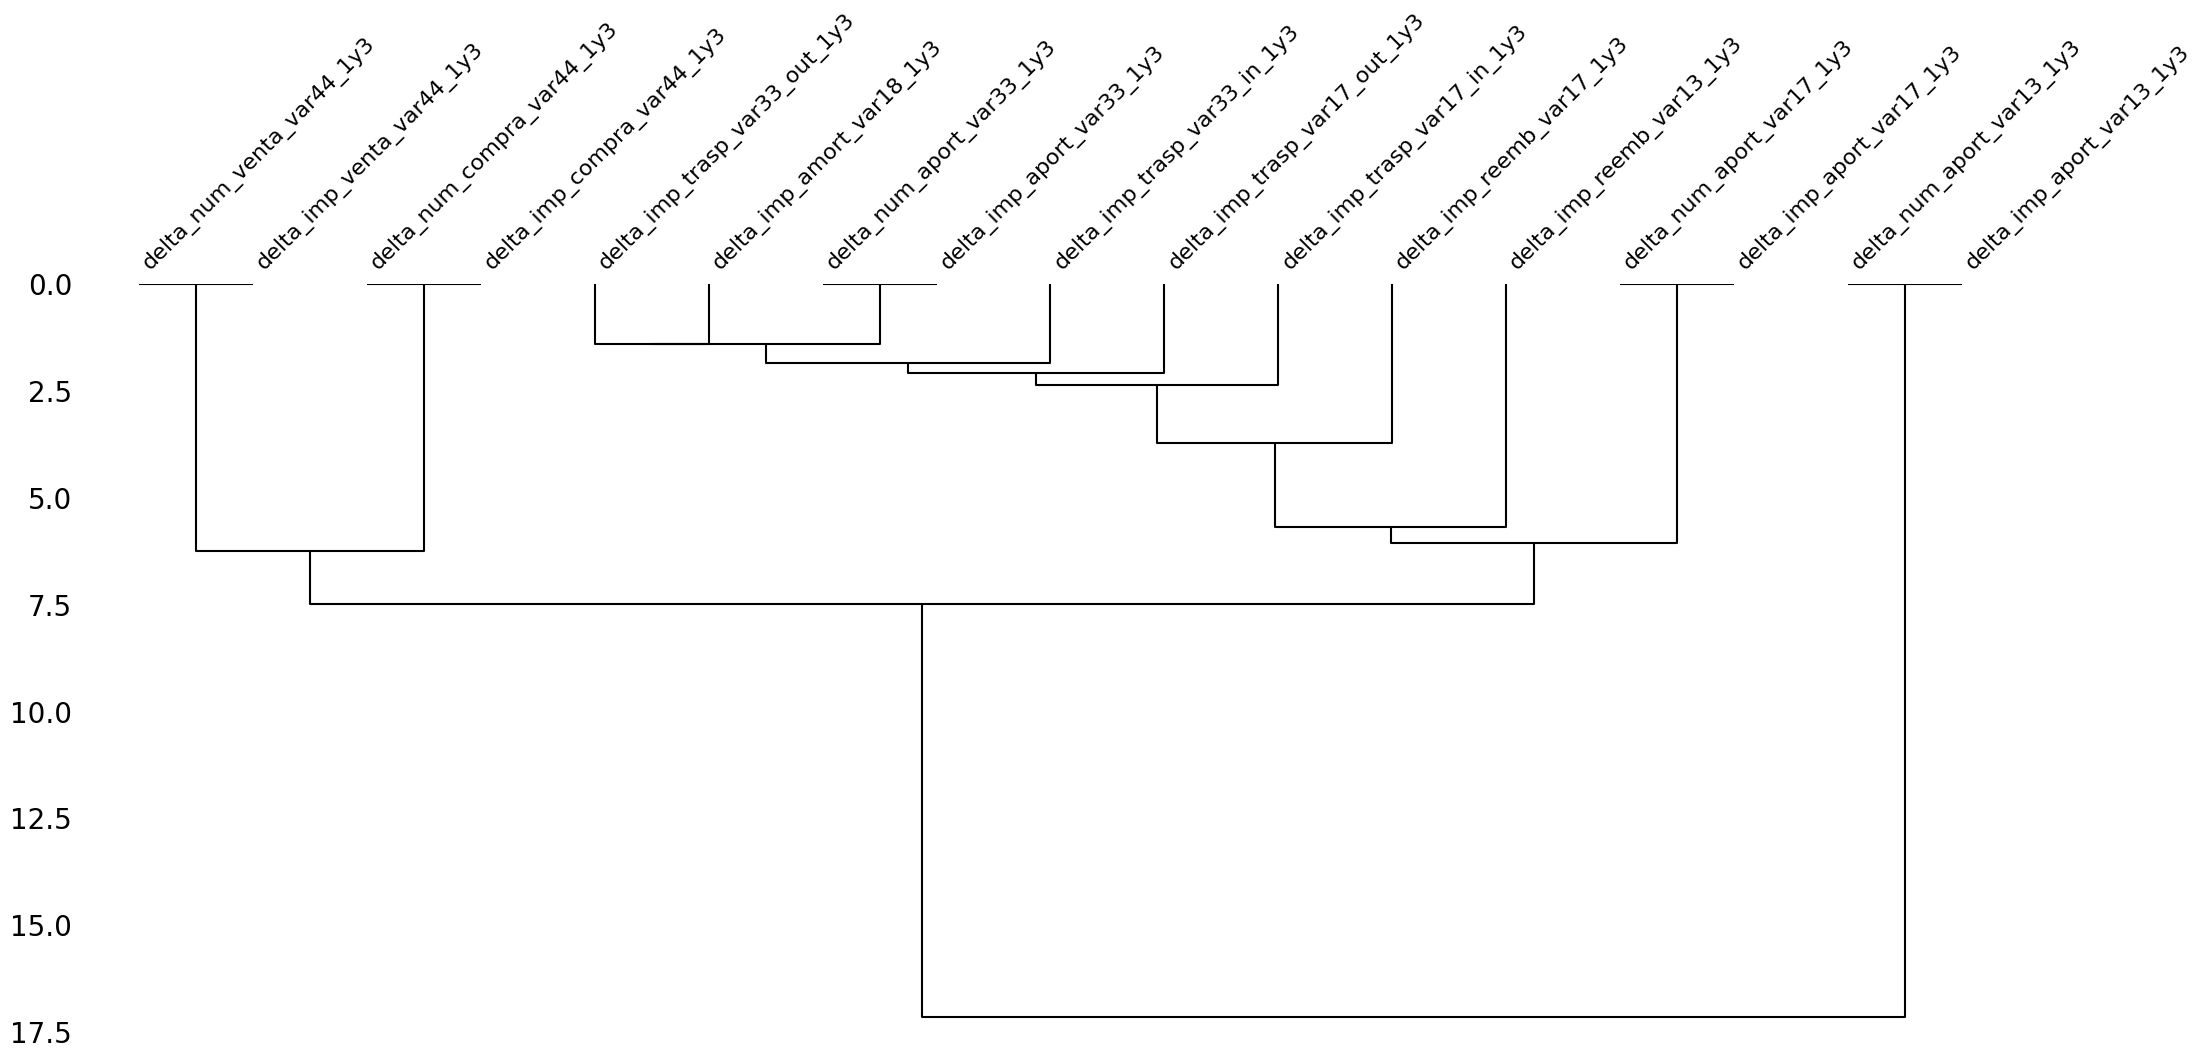

In [17]:
#| label: delta-missing
#| echo: true
#| code-fold: show
#| code-summary: "Código"
# Biblioteca missingno, disponível no PyPi
mno.matrix(df[delta_cols])
plt.show()
mno.dendrogram(df[delta_cols])
plt.show()

#### Feature Engineering

##### Contagem de nulos

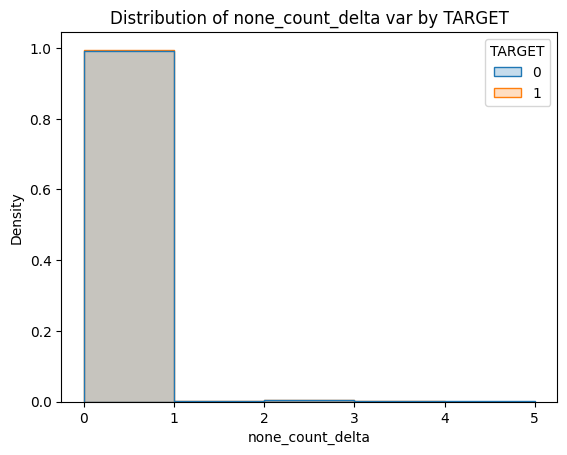

In [18]:
#| label: delta-missingcount
#| echo: true
#| code-fold: true
#| code-summary: "Código"
anc_delta = AddNoneCount(prefix="delta")
anc_delta = anc_delta.fit(df)
df = anc_delta.transform(df)
col = "none_count_delta"
cv.binaryhistplot(df[col], df["TARGET"], nbins=5)

##### Contagem de colunas diferentes de 0

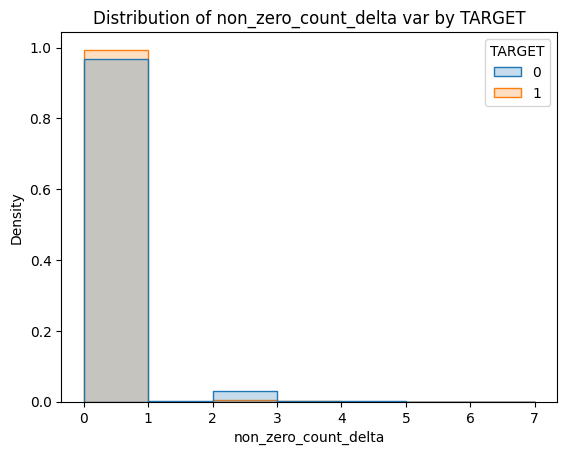

In [19]:
#| label: delta-nonzero
#| echo: true
#| code-fold: true
#| code-summary: "Código"
anzc_delta = AddNonZeroCount(prefix="delta")
anzc_delta = anzc_delta.fit(df)
df = anzc_delta.transform(df)
col = "non_zero_count_delta"
cv.binaryhistplot(df[col], df["TARGET"], nbins=7)

##### Soma total das colunas

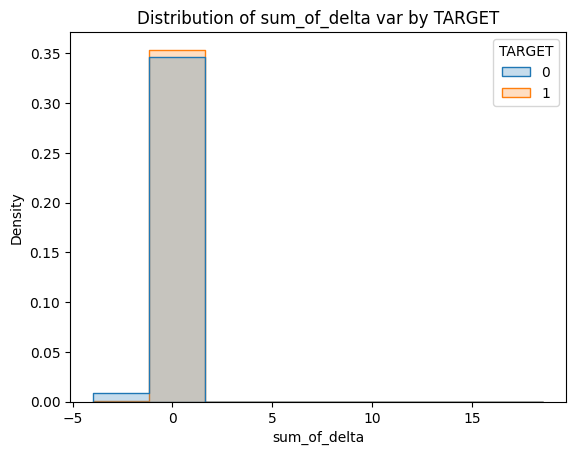

In [20]:
#| label: delta-sum
#| echo: true
#| code-fold: true
#| code-summary: "Código"
cs_delta = CustomSum(prefix="delta")
cs_delta = cs_delta.fit(df)
df = cs_delta.transform(df)
col = "sum_of_delta"
min_sum = df[col].min()
cv.binaryhistplot(df[col], df["TARGET"], nbins=8)

### Ind

Estas variáveis são compostas exclusivamente por valores de 0 e 1, ou seja, são variáveis binárias.

Neste caso, como as variáveis já são binarizadas, a análise é mais simples. Não há nenhum outlier que chame a atenção ou levante suspeitas de ser, na verdade, algum valor faltante.

Foi criada a coluna de contagem de valores diferentes de zero e percebe-se que observações com "TARGET" = 1 se concentram em valores mais baixos de contagem.

In [21]:
#| label: ind-describe
#| echo: true
#| code-fold: true
#| code-summary: "Código"
ind_cols = [
    col
    for col in df.columns
    if col.startswith("ind")
]
df[ind_cols].describe().loc[["min", "max"]]

,ind_var1_0,ind_var1,ind_var5_0,ind_var5,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13_largo,ind_var13,ind_var14_0,ind_var14,ind_var17_0,ind_var17,ind_var18,ind_var19,ind_var20_0,ind_var20,ind_var24_0,ind_var24,ind_var25_cte,ind_var26_cte,ind_var26,ind_var25,ind_var29_0,ind_var29,ind_var30_0,ind_var30,ind_var31_0,ind_var31,ind_var32_cte,ind_var32,ind_var33_0,ind_var33,ind_var37_cte,ind_var37,ind_var39_0,ind_var40_0,ind_var41_0,ind_var39,ind_var44_0,ind_var44,ind_var7_emit_ult1,ind_var7_recib_ult1,ind_var10_ult1,ind_var10cte_ult1,ind_var9_cte_ult1,ind_var9_ult1,ind_var43_emit_ult1,ind_var43_recib_ult1
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [22]:
df[ind_cols].nunique().max()

2

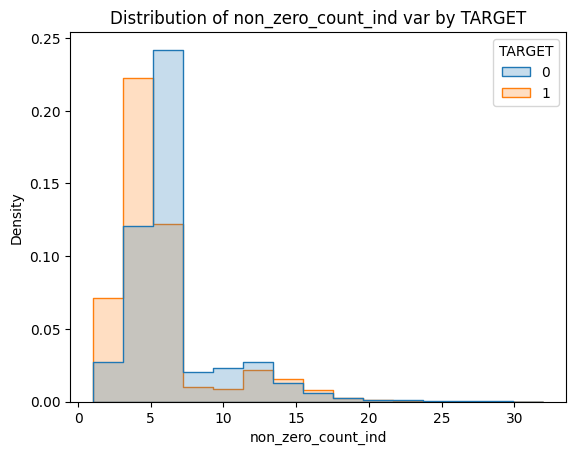

In [23]:
#| label: ind-nonzero
#| echo: true
#| code-fold: true
#| code-summary: "Código"
anzc_ind = AddNonZeroCount(prefix="ind")
anzc_ind = anzc_ind.fit(df)
df = anzc_ind.transform(df)
col = "non_zero_count_ind"
cv.binaryhistplot(df[col], df["TARGET"], nbins=15)

### Num

O prefixo indica que as variáveis sejam uma contagem ("número de vendas", "número de recibos"). O fato de não haver nenhum valor negativo nem nenhum número decimal corrobora com esta ideia. Também não há um valor exorbitante comum entre as colunas, indicando que estes dados não tiveram valores faltantes preenchidos artificialmente.

Percebe-se que tanto na contagem de valores diferentes de zero quanto na soma do subconjunto, clientes insatisfeitos se concentram de forma diferente de clientes satisfeitos.

#### Verificações generalizadas

In [24]:
#| label: num-describe
#| echo: true
#| code-fold: true
#| code-summary: "Código"
num_cols = [
    col
    for col in df.columns
    if col.startswith("num")
]
df[num_cols].describe()

,num_var1_0,num_var1,num_var4,num_var5_0,num_var5,num_var8_0,num_var8,num_var12_0,num_var12,num_var13_0,num_var13_corto_0,num_var13_corto,num_var13_largo_0,num_var13_largo,num_var13,num_var14_0,num_var14,num_var17_0,num_var17,num_var18,num_var20_0,num_var20,num_var24_0,num_var24,num_var26,num_var25,num_op_var40_hace2,num_op_var40_hace3,num_op_var40_ult1,num_op_var40_ult3,num_op_var41_hace2,num_op_var41_hace3,num_op_var41_ult1,num_op_var41_ult3,num_op_var39_hace2,num_op_var39_hace3,num_op_var39_ult1,num_op_var39_ult3,num_var29_0,num_var29,num_var30_0,num_var30,num_var31_0,num_var31,num_var32,num_var33_0,num_var33,num_var35,num_var37_med_ult2,num_var37,num_var39_0,num_var40_0,num_var41_0,num_var39,num_var42_0,num_var42,num_var44_0,num_var44,num_aport_var13_hace3,num_aport_var13_ult1,num_aport_var17_hace3,num_aport_var17_ult1,num_aport_var33_hace3,num_aport_var33_ult1,num_var7_emit_ult1,num_var7_recib_ult1,num_compra_var44_hace3,num_compra_var44_ult1,num_ent_var16_ult1,num_var22_hace2,num_var22_hace3,num_var22_ult1,num_var22_ult3,num_med_var22_ult3,num_med_var45_ult3,num_meses_var5_ult3,num_meses_var8_ult3,num_meses_var12_ult3,num_meses_var13_corto_ult3,num_meses_var13_largo_ult3,num_meses_var17_ult3,num_meses_var29_ult3,num_meses_var33_ult3,num_meses_var39_vig_ult3,num_meses_var44_ult3,num_op_var39_comer_ult1,num_op_var39_comer_ult3,num_op_var40_comer_ult1,num_op_var40_comer_ult3,num_op_var40_efect_ult1,num_op_var40_efect_ult3,num_op_var41_comer_ult1,num_op_var41_comer_ult3,num_op_var41_efect_ult1,num_op_var41_efect_ult3,num_op_var39_efect_ult1,num_op_var39_efect_ult3,num_reemb_var13_ult1,num_reemb_var17_hace3,num_reemb_var17_ult1,num_sal_var16_ult1,num_var43_emit_ult1,num_var43_recib_ult1,num_trasp_var11_ult1,num_trasp_var17_in_hace3,num_trasp_var17_in_ult1,num_trasp_var17_out_ult1,num_trasp_var33_in_hace3,num_trasp_var33_in_ult1,num_trasp_var33_out_ult1,num_venta_var44_hace3,num_venta_var44_ult1,num_var45_hace2,num_var45_hace3,num_var45_ult1,num_var45_ult3
count,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.00000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.00000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.00000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000,57015.000000
mean,0.033517,0.010524,1.081312,2.894712,1.999105,0.098763,0.085977,0.212839,0.139069,0.168956,0.129966,0.124283,0.038990,0.036885,0.161168,0.073402,0.016259,0.012681,0.009471,0.000053,0.010366,0.007524,0.129071,0.115285,0.089976,0.085977,0.021415,0.001210,0.054828,0.077453,1.619521,0.092555,2.867929,4.580005,1.640937,0.093765,2.922757,4.657459,0.000421,0.000105,3.375691,2.385425,0.020784,0.016417,0.003999,0.00221,0.001684,3.304499,0.268719,0.425046,2.724809,0.033465,2.699658,0.010471,3.206735

In [25]:
df[num_cols] \
    .nunique() \
    .nlargest(10) \
    .reset_index() \
    .rename(
        mapper={
            "index": "Column",
            0: "Number of unique values"
        },
        axis=1
    )

,Column,Number of unique values
0,num_var45_ult3,157
1,num_op_var39_ult3,95
2,num_op_var41_ult3,92
3,num_op_var39_comer_ult3,88
4,num_op_var41_comer_ult3,85
5,num_var45_ult1,85
6,num_var45_hace2,76
7,num_op_var39_ult1,66
8,num_med_var45_ult3,64
9,num_op_var41_ult1,62


In [26]:
nfloat = df[num_cols].applymap(lambda x: 0 if x%1 == 0 else 1).sum().sum()
print(f"Contagem de números decimais: {nfloat}")

Contagem de números decimais: 0


#### Feature Engineering

##### Contagem de colunas diferentes de 0

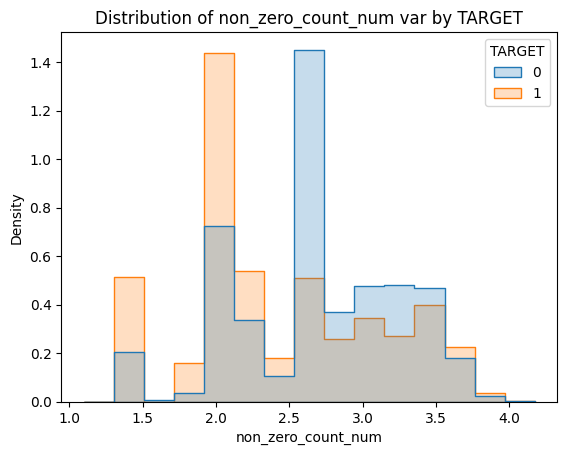

In [27]:
#| label: num-nonzero
#| echo: true
#| code-fold: true
#| code-summary: "Código"
anzc_num = AddNonZeroCount(prefix="num")
anzc_num = anzc_num.fit(df)
df = anzc_num.transform(df)
col = "non_zero_count_num"
cv.binaryhistplot(
    df[col].apply(np.log1p),
    df["TARGET"],
    nbins=15
)

##### Soma total das colunas

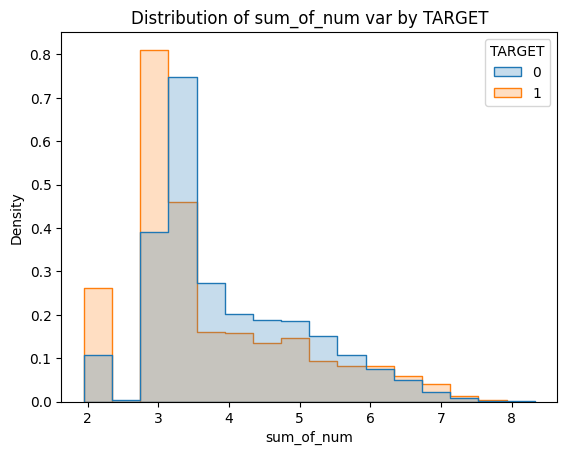

In [28]:
#| label: num-sum
#| echo: true
#| code-fold: true
#| code-summary: "Código"
cs_num = CustomSum(prefix="num")
cs_num = cs_num.fit(df)
df = cs_num.transform(df)
col = "sum_of_num"
cv.binaryhistplot(
    df[col].apply(np.log1p),
    df["TARGET"],
    nbins=16
)

### Demais variáveis

Por fim, foram encontradas variáveis sem prefixos. Como são poucas variáveis, optou-se por tratá-las uma a uma, pois sem prefixo não podemos assumir que se tratam de grandezas semelhantes nem que são do mesmo tipo (contínua, discreta, categórica, etc).

O ideal seria abordar todas as variáveis desta forma -- não apenas individualmente, mas também tentando encontrar relações entre as variáveis.

#### Verificações generalizadas

In [29]:
remaining_cols = [
    col
    for col in df.columns
    if (
        (col not in imp_cols)
        & (col not in ind_cols)
        & (col not in num_cols)
        & (col not in saldo_cols)
        & (col not in delta_cols)
        & ("count" not in col)
        & ("sum" not in col)
        & ("avg" not in col)
        & (col not in ["TARGET", "ID"])
    )
]

In [30]:
df[remaining_cols].describe()

,var3,var15,var36,var21,var38
count,57015.000000,57015.000000,57015.000000,57015.000000,5.701500e+04
mean,-1523.211874,33.229624,40.467228,31.965272,1.179580e+05
std,39033.547421,12.957207,47.367241,393.934733,1.947151e+05
min,-999999.000000,5.000000,0.000000,0.000000,5.163750e+03
25%,2.000000,23.000000,2.000000,0.000000,6.775136e+04
50%,2.000000,28.000000,3.000000,0.000000,1.064813e+05
75%,2.000000,40.000000,99.000000,0.000000,1.188111e+05
max,238.000000,105.000000,99.000000,30000.000000,2.203474e+07


In [31]:
df[remaining_cols] \
    .nunique() \
    .reset_index() \
    .rename(
        mapper={
            "index": "Column",
            0: "Number of unique values"
        },
        axis=1
    )

,Column,Number of unique values
0,var3,186
1,var15,100
2,var36,5
3,var21,21
4,var38,43895


#### var3

Esta variável possui 192 valores únicos, incluindo um único valor negativo de -999999 que se repete 93 vezes. Este valor foi considerado como faltante e substituído por "None", pelo motivo explicado na seção do prefixo "delta". Não há números decimais, apenas inteiros. Assume-se que é uma variável de contagem. A variável não parece ter poder de discriminação, embora a concentração de clientes insatisfeitos seja menor para valores nulos. Para a floresta aleatória, foi criada uma outra coluna indicadora para valor faltante desta variável.

In [32]:
col = "var3"
nfloat = df[col].apply(lambda x: 0 if x%1 == 0 else 1).sum()
print(f"Contagem de números decimais: {nfloat}")

Contagem de números decimais: 0


In [33]:
#| label: var3-missing
#| echo: true
#| code-fold: true
#| code-summary: "Código"
col = "var3"
ci_var3 = CustomImputer(prefix="var3", to_replace=-999999)
ci_var3 = ci_var3.fit(df)
df = ci_var3.transform(df)
df \
    .assign(null = df[col].isna().astype(int)) \
    .groupby("null")["TARGET"] \
    .value_counts(normalize=True) \
    .unstack()

TARGET,0,1
null,,
0,0.960406,0.039594
1,0.977011,0.022989


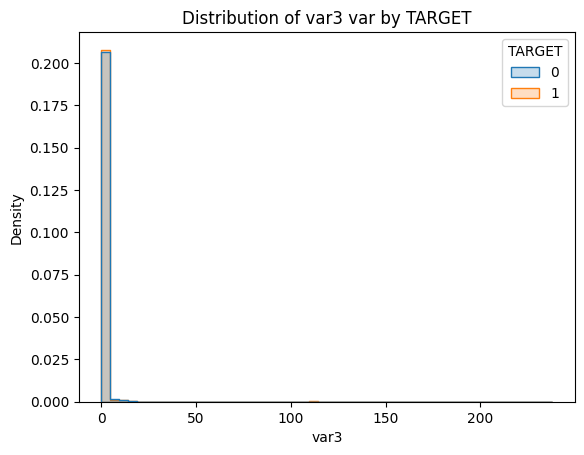

In [34]:
#| label: var3
#| echo: true
#| code-fold: true
#| code-summary: "Código"
col = "var3"
cv.binaryhistplot(df[col], df["TARGET"], nbins=50)

#### var15

Esta variável possui 100 valores únicos entre 5 e 105. Não há valores decimais. Todas estas características levam a acreditar que esta variável se trata da idade do cliente -- o que faz algum sentido, dada a escassez de clientes menores de 18 anos, que provavelmente é resultado de alguma política do banco. Assumiu-se que é uma variável numérica, sem necessidade de qualquer outro tratamento.

Neste caso, as distribuições de clientes satisfeitos e insatisfeitos são bem diferentes, levando a acreditar que a variável possui poder de discriminação.

In [35]:
col = "var15"

nfloat = df[col].apply(lambda x: 0 if x%1 == 0 else 1).sum()
print(f"Contagem de números decimais: {nfloat}")

Contagem de números decimais: 0


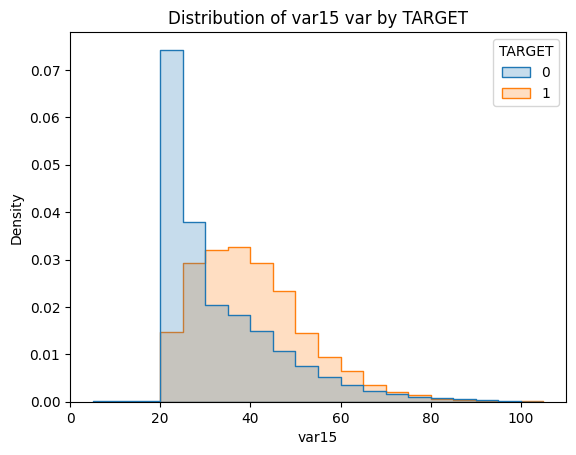

In [36]:
#| label: var15
#| echo: true
#| code-fold: true
#| code-summary: "Código"
col = "var15"
cv.binaryhistplot(df[col], df["TARGET"], nbins=20)

#### var36

Esta variável aparenta ser uma variável categórica com labels não ordinais. Para a floresta aleatória, será interessante aplicar um Target Encoder customizado para que as categorias sejam ordenadas com base na proporção de clientes insatisfeitos. Já para modelos lineares e análise de cluster, One Hot Encoding ou Weight of Evidence podem ser mais interessantes. O valor 99 aparenta ser artificial, mas será considerado como uma categoria por ser muito representativo.

Os modelos de _boosting_, por outro lado, possuem métodos nativos para lidar com variáveis categóricas, mas exigem que seus _labels_ sejam números inteiros variando de 0 a _nfeatures_-1. Assim, o tratamento será o mesmo que no caso da floresta por pura conveniência.

In [37]:
var = "var36"

ordered_df = df \
    .groupby(var)["TARGET"] \
    .value_counts(normalize=True) \
    .unstack() \
    .sort_values(by=0, ascending=False) \
    .merge(
        df[var] \
            .value_counts() \
            .reset_index() \
            .set_index(var),
        left_index=True,
        right_index=True
    )

ordered_df

,0,1,count
var36,,,
0,1.000000,NaN,302
3,0.983975,0.016025,16599
2,0.970058,0.029942,6546
1,0.968026,0.031974,11009
99,0.936079,0.063921,22559


In [38]:
#| label: var36
#| echo: true
#| code-fold: true
#| code-summary: "Código"
CE_var36 = CustomEncoder(colname="var36")
CE_var36 = CE_var36.fit(df.drop("TARGET", axis=1), df["TARGET"])
df = CE_var36.transform(df)
ordered_df = df \
    .groupby(var)["TARGET"] \
    .value_counts(normalize=True) \
    .unstack() \
    .sort_values(by=0, ascending=False) \
    .merge(
        df[var] \
            .value_counts() \
            .reset_index() \
            .set_index(var),
        left_index=True,
        right_index=True
    )
ordered_df

,0,1,count
var36,,,
0,1.000000,NaN,302
1,0.983975,0.016025,16599
2,0.970058,0.029942,6546
3,0.968026,0.031974,11009
4,0.936079,0.063921,22559


#### var21

Outra variável que aparenta ser categórica com labels não ordinais. Os mesmos tratamentos de var36 foram escolhidos.

In [39]:
var = "var21"

ordered_df = df \
    .groupby(var)["TARGET"] \
    .value_counts(normalize=True) \
    .unstack() \
    .sort_values(by=0, ascending=False) \
    .merge(
        df[var] \
            .value_counts() \
            .reset_index() \
            .set_index(var),
        left_index=True,
        right_index=True
    )

ordered_df

,0,1,count
var21,,,
30000,1.000000,NaN,1
5400,1.000000,NaN,2
1200,1.000000,NaN,8
1500,1.000000,NaN,20
18000,1.000000,NaN,2
9000,1.000000,NaN,9
2400,1.000000,NaN,3
2700,1.000000,NaN,23
3300,1.000000,NaN,2


In [40]:
#| label: var21
#| echo: true
#| code-fold: true
#| code-summary: "Código"
CE_var21 = CustomEncoder(colname="var21")
CE_var21 = CE_var21.fit(df.drop("TARGET", axis=1), df["TARGET"])
df = CE_var21.transform(df)
ordered_df = df \
    .groupby(var)["TARGET"] \
    .value_counts(normalize=True) \
    .unstack() \
    .merge(
        df[var] \
            .value_counts() \
            .reset_index() \
            .set_index(var),
        left_index=True,
        right_index=True
    )
ordered_df

,0,1,count
var21,,,
0,1.000000,NaN,1
1,1.000000,NaN,9
2,1.000000,NaN,8
3,1.000000,NaN,20
4,1.000000,NaN,20
5,1.000000,NaN,3
6,1.000000,NaN,23
7,1.000000,NaN,1
8,1.000000,NaN,2


#### var38
Já esta variável aparenta ser numérica, dada a grande quantidade de valores únicos e presença majoritária de números decimais. As ditribuições de clientes satisfeitos e insatisfeitos são muito parecidas, indicando que a variável não tem grande poder de discriminação.

In [41]:
var = "var38"

nfloat = df[var] \
    .apply(
        lambda x:
            0
            if x%1 == 0
            else 1
        ) \
    .sum() \
    / len(df) * 100

print(f"Números decimais: {nfloat:.2f} %")

Números decimais: 99.08 %


In [42]:
df[[var]].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
var38,57015.0,117957.96857,194715.060906,5163.75,67751.355,106481.34,118811.055,22034738.76


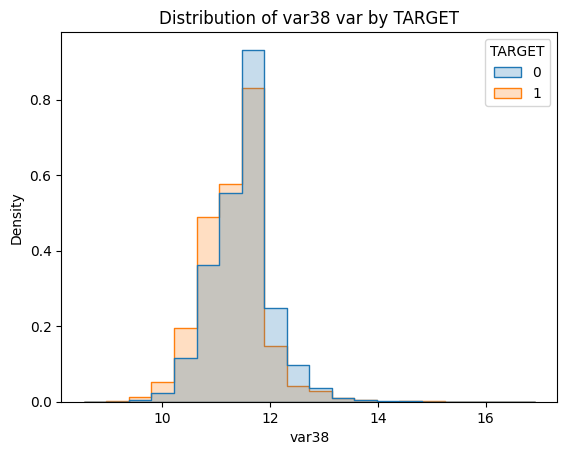

In [43]:
#| label: var38
#| echo: true
#| code-fold: true
#| code-summary: "Código"
var = "var38"
cv.binaryhistplot(
    df[var].apply(np.log1p),
    df["TARGET"],
    nbins=20
)